## Multi-node Parallelism and Dask

### Concepts of Multi-node Jobs and Distributed Computing
- **Multi-node parallelism**: When a single job uses multiple nodes, it allows distributed computing across nodes to solve larger problems. This requires breaking down tasks and distributing them efficiently across nodes.
- **Advantages of distributed computing**: Utilizing multiple nodes allows scaling workloads beyond the limits of a single machine. Examples:
  - Parallelizing large dataframes and arrays
  - Machine learning on large datasets (Training models on data that won’t fit into memory), leveraging libraries like Dask-ML
  - Distributed hyperparameter tuning
  - ETL and data pipelines
  - Interactive data analysis
- **Challenges**:
  - **Efficient distribution of tasks**: Breaking tasks into smaller units that can be executed independently is crucial for maximizing parallel efficiency.
  - **Minimizing communication overhead**: Communication between nodes can slow down processing. Efficient algorithms aim to reduce the amount of inter-node communication.
  - **Handling data dependencies**: Dependencies between tasks can limit parallelism. Identifying independent tasks and minimizing dependencies are key to effective multi-node parallelism.

### Introduction to Dask
- **Dask collections**: Dask collections are high-level abstractions that provide distributed versions of familiar data structures.
  - **Delayed**: Lazy evaluation that allows you to construct a task graph and execute it only when required. This is useful for breaking down complex computations into smaller, manageable tasks.
  - **Dask Array**: Parallelized version of NumPy arrays that can be distributed across multiple nodes.
  - **Dask DataFrame**: Parallelized version of Pandas DataFrames that can be distributed across multiple nodes.
  - **Dask Bag**: Parallelized version of Python iterators that can be distributed across multiple nodes.
  - **Dask ML**: Distributed machine learning library that can scale scikit-learn workflows to large datasets.

In [1]:
import dask

# Delayed: Delay computation until it is needed

def add(x, y):
    return x + y
delayed_add = dask.delayed(add)(5, 6)

In [2]:
print(delayed_add)

Delayed('add-6c7530f5-7f69-446a-b409-24949d85484d')


In [3]:
result = delayed_add.compute()  # Trigger computation
print(result)  

11


**Visualizing task graphs:** Dask provides visualization tools to understand the task dependencies.

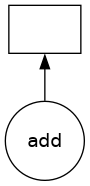

In [4]:
# Visualize a task graph
delayed_add.visualize()

In [5]:
# Dask Array: Parallel NumPy arrays

import dask.array as da
import numpy as np

x = np.random.rand(10000)
y = np.random.rand(10000)
dx = da.from_array(x, chunks=len(x)//4)
dy = da.from_array(y, chunks=len(y)//4)
result = (dx + dy).sum()
print(result.compute())

9992.16562410717


In [6]:
# Dask DataFrame: Parallel Pandas DataFrames

import dask.dataframe as dd
import pandas as pd

df = pd.DataFrame({'x': np.random.randint(0, 10, size=10000), 'y': np.random.rand(10000)})
ddf = dd.from_pandas(df, npartitions=4)
result = ddf.groupby('x').y.mean()
print(result.compute())


x
0    0.511749
1    0.502064
2    0.492546
3    0.510551
4    0.500531
5    0.502013
6    0.497210
7    0.514784
8    0.482721
9    0.493922
Name: y, dtype: float64


In [7]:
# Dask Bag: Parallel Python lists

import dask.bag as db

b = db.from_sequence(range(10000), npartitions=4)
result = b.map(lambda x: x**2).filter(lambda x: x % 2 == 0).sum()
print(result.compute())

166616670000


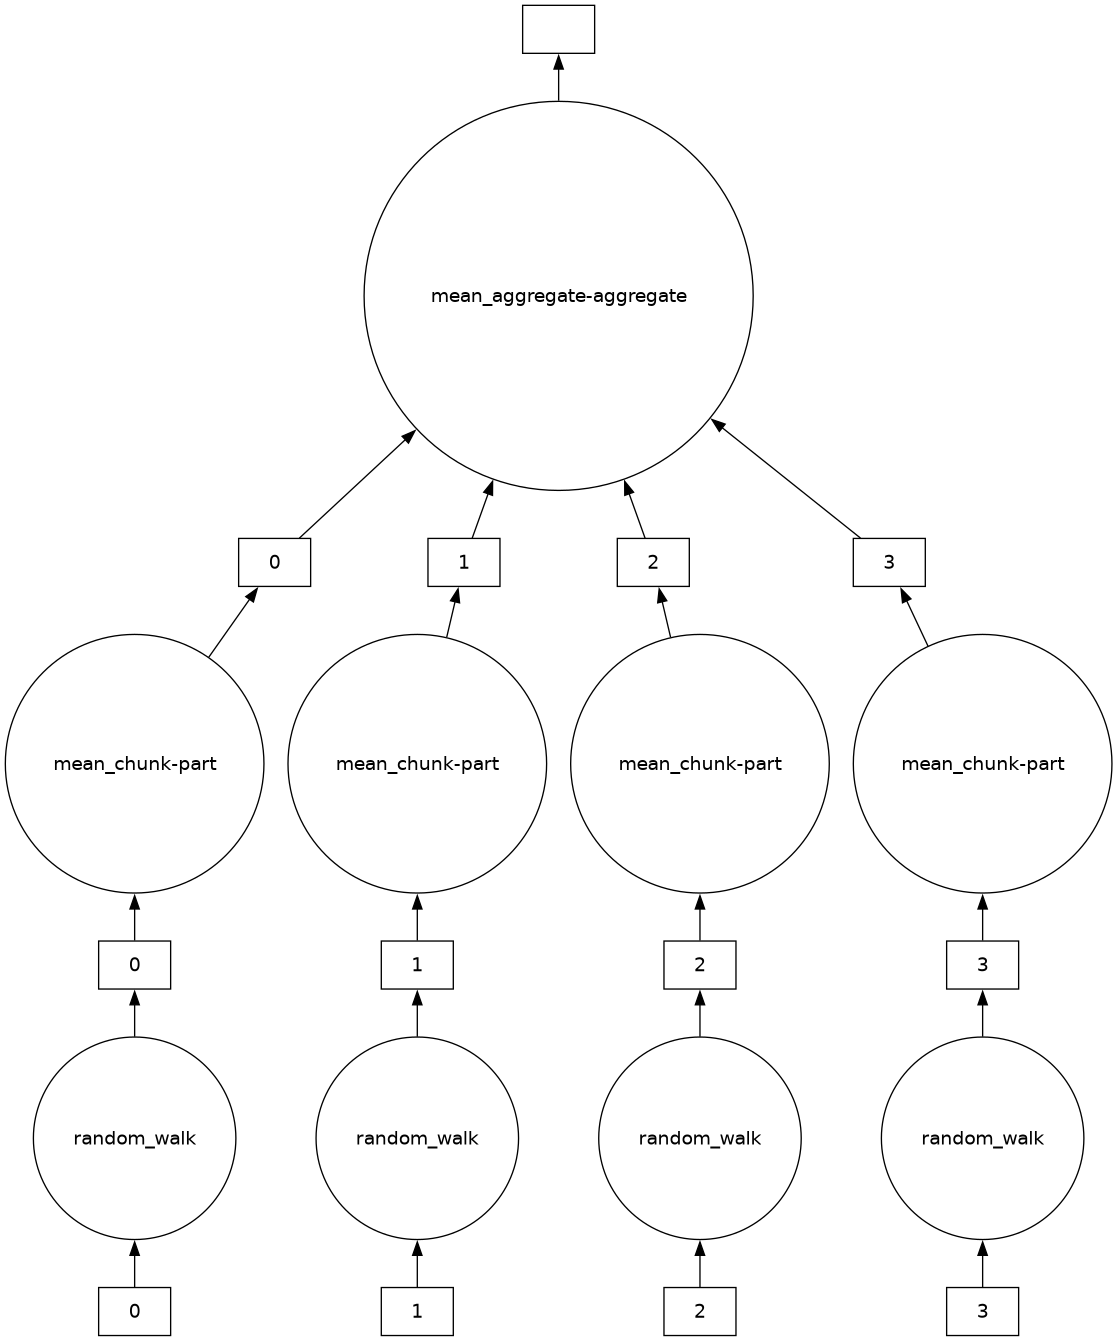

In [8]:
# Create a more complex task graph for visualization
import random

def random_walk(n):
    x = 0
    for _ in range(n):
        x += random.choice([-1, 1])
    return x

b = db.from_sequence(range(1000), npartitions=4)

result = b.map(random_walk).mean()
result.visualize()


In [9]:
print(result.compute())

-1.5


### Running Dask Jobs on Palmetto2
- **Using Dask with SLURM**: Dask jobs can be executed on Palmetto by leveraging SLURM to allocate nodes and manage resources. Dask can then orchestrate the distributed computation across the allocated nodes. Here's a simple example of a SLURM script to run a Dask job:
```bash
#!/bin/bash
#SBATCH --job-name=dask_job
#SBATCH --nodes=2
#SBATCH --ntasks-per-node=2
#SBATCH --time=01:00:00
#SBATCH --output=dask_output.log

module load anaconda3  # Load Anaconda

# Ensure the conda environment is accessible across nodes
export PATH=$HOME/.conda/envs/hpc_ml/bin:$PATH

# Get the hostnames of the allocated nodes
hostnames=$(scontrol show hostnames $SLURM_JOB_NODELIST)

# Start the Dask scheduler on the first node
first_node=$(echo $hostnames | awk '{print $1}')
ssh $first_node "
    module load anaconda3 &&
    source activate hpc_ml &&
    dask-scheduler --scheduler-file=scheduler.json &
" &

# Start Dask workers on all nodes
for node in $hostnames; do
    ssh $node "
        module load anaconda3 &&
        source activate hpc_ml &&
        dask-worker --scheduler-file=scheduler.json --nthreads=1 --nprocs=2 --memory-limit=0 &
    " &
done

# Wait for all processes to complete
wait
```

Save the above as, e.g., `dask_job.slurm`, and submit it using `sbatch dask_job.slurm`. Then you can use `ssh` to connect to the first node and run your Dask code. Make sure your code points to the scheduler file (`scheduler.json`) to connect to the Dask cluster. For example, your code could be a .py file that looks like the following:

```python
from dask.distributed import Client
import dask.array as da

# Connect to the Dask scheduler
client = Client(scheduler_file='scheduler.json')

# Example: Creating a random Dask array and performing a computation
x = da.random.random((10000, 10000), chunks=(1000, 1000))
result = x.mean().compute()

print("Mean of the array:", result)
```

If you save this as `dask_example.py`, you can run it by using `ssh` to connect to the first node running your Dask job and then running `python dask_example.py`.